# Step1: Dataset Prepration
Use the graph dataset and load it in readable format in memory

In [1]:
import os
import networkx as nx
import pandas as pd

# Path to extracted files
graphml_dir = 'input/exported_aws_graphs'

# List all graph files
graph_files = [os.path.join(graphml_dir, f) for f in os.listdir(graphml_dir) if f.endswith('.graphml')]

# Initialize data storage
architectures = []

################################ For debugging and checking Graph Data #################################

# Inspect node attributes dynamically
# for graph_file in graph_files[:1]:  # Check just one file for debugging
#     graph = nx.read_graphml(graph_file)
#     for node in graph.nodes:
#         print(f"Node ID: {node}, Attributes: {graph.nodes[node]}")

# Inspect edge attributes dynamically
# for graph_file in graph_files[:1]:  # Check just one file for debugging
#     graph = nx.read_graphml(graph_file)
#     for edge in graph.edges(data=True):
#         print(f"Edge: {edge}")

# Inspect graph attributes dynamically
# for graph_file in graph_files[:1]:  # Check just one file for debugging
#     graph = nx.read_graphml(graph_file)
#     print("Graph Metadata:", graph.graph)

##########################################################################################################

# Process each graph file
for graph_file in graph_files:
    graph = nx.read_graphml(graph_file)
    architecture_id = os.path.basename(graph_file).split('.')[0]

    # Extract node details
    nodes = {
        node: {
            "service": graph.nodes[node].get('service', 'NULL'),
            "human_name": graph.nodes[node].get('human_name', 'NULL'),
            "info": graph.nodes[node].get('info', '')
        }
        for node in graph.nodes
    }

    
    # Map nodes to services
    services = [data['service'] for data in nodes.values()]
    
    # Extract edges with meaningful details
    edges = [
        {
            "source": nodes[src]["service"],
            "target": nodes[dst]["service"],
            "type": edge_data.get('type', 'NULL')
        }
        for src, dst, edge_data in graph.edges(data=True)  # Unpack the edge attributes
    ]
    
    # Add processed architecture
    architectures.append({
        "id": architecture_id,
        "services": services,
        "edges": edges,
        "name": graph.graph.get('name', 'Unnamed Architecture'),
        "link": graph.graph.get('link', ''),
        "categories": graph.graph.get('categories', ''),
        "notes": graph.graph.get('notes', '')
    })

# Convert to DataFrame
architecture_df = pd.DataFrame(architectures)

# Display the processed data
print(architecture_df.head())

# Save to CSV for further analysis
architecture_df.to_csv('output/architectures.csv', index=False)


            id                                           services  \
0  vb-o1DvvHxk  [ELB, BeanStalk, ApiGateway, Lambda, Lambda, S...   
1  WtCfHP6rUAY  [UserCompanyDataStream, UserCompanyAPI, Lambda...   
2  dy-drIboyNA  [UserConsumerAPI, UserConsumerAPI, S3, S3, Api...   
3  D77FSUkPJ3o  [UserConsumerWeb, ELB, ThirdParty, ECS, S3, La...   
4  illMCyp4O9A  [EC2, SQS, DynamoDB, BeanStalk, Kinesis, S3, U...   

                                               edges  \
0  [{'source': 'ELB', 'target': 'BeanStalk', 'typ...   
1  [{'source': 'UserCompanyDataStream', 'target':...   
2  [{'source': 'UserConsumerAPI', 'target': 'ApiG...   
3  [{'source': 'UserConsumerWeb', 'target': 'Thir...   
4  [{'source': 'EC2', 'target': 'UserConsumerEdge...   

                                                name  \
0           Enoptea: PHP Layer for AWS Lambda French   
1         Coople: Serverless CQRS and Event Sourcing   
2  Healthdirect Australia: Using AWS to Connect P...   
3  Avio Aero, a GE Aviat

# Step2: Find all the unique AWS services among all the architectures
    - Create a list of all the unique services as all_services and keep appending all the unique services to it

In [2]:
all_services = []
for i in range(len(architectures)):
    for service in architectures[i]['services']:
        if service not in all_services:
            all_services.append(service)

# Remove entries which contains "User" or "ThirdParty" in all_services
# This is done to remove the user created services from the list
all_services = [service for service in all_services if "User" not in service]
all_services = [service for service in all_services if "ThirdParty" not in service]

all_services = sorted(all_services)

# Save all_services to a csv file
all_services_df = pd.DataFrame(all_services)
all_services_df.to_csv('output/aws_services.csv', index=False)

# Step3: Load the compatibitliy matrix from the JSON file
    - Mapping AWS services to Azure and GCP counterparts
    - This needs to be researched and created manually
    - One good reference is : https://github.com/milanm/Cloud-Product-Mapping

# Example of service_mapping:
```python
service_mapping = {
    "S3": {"Azure": "Blob Storage", "GCP": "Cloud Storage", "Compatibility": "Fully Compatible"},
    "Lambda": {"Azure": "Functions", "GCP": "Cloud Functions", "Compatibility": "Fully Compatible"},
    "Athena": {"Azure": None, "GCP": None, "Compatibility": "Incompatible"},
    "DynamoDB": {"Azure": "Cosmos DB", "GCP": "Firestore", "Compatibility": "Partially Compatible"},
    # Add more mappings as needed
}
```

In [3]:
import json
with open('input/compatibility_matrix_2.json', 'r') as file:
    service_mapping = json.load(file)

# Convert mapping to DataFrame
mapping_df = pd.DataFrame.from_dict(service_mapping, orient='index')
mapping_df.index.name = "AWS"
print(mapping_df)

# Save mapping for later reference
mapping_df.to_csv('output/service_mapping.csv')


                                       Azure                    GCP  \
AWS                                                                   
ACM                 App Service Certificates    Certificate Manager   
ALB                      Application Gateway   Cloud Load Balancing   
AMI             Azure Virtual Machine Images          Custom Images   
AWSConfig                       Azure Policy  Cloud Asset Inventory   
AccessAnalyzer                 Azure Monitor       Cloud Audit Logs   
...                                      ...                    ...   
VPCPeering           Virtual Network Peering            VPC Peering   
VPN                              VPN Gateway              Cloud VPN   
WAF                 Web Application Firewall            Cloud Armor   
WorkSpaces             Azure Virtual Desktop                   None   
XRay                    Application Insights            Cloud Trace   

                       Compatibility  
AWS                                  

# Step4: Compute the lock-in index for all the architectures
It computes how many services in each architectures are incompatible or partially compatible

In [4]:
# Calcualte Lock-In Index
# Define weights
weights = {
    'Fully Compatible': 0,
    'Partially Compatible': 0.5,
    'Incompatible': 1
}

# Merge architectures with service mapping
# def compute_lock_in_index(services):
#     proprietary_count = sum(1 for s in services if service_mapping.get(s, {}).get("Compatibility") != "Fully Compatible")
#     return proprietary_count / len(services) if services else 0


# Function to calculate Lock-In Index
def compute_lock_in_index(services):
    total_weight = 0
    for service in services:
        compatibility = service_mapping.get(service, {}).get('Compatibility', '')
        total_weight += weights.get(compatibility, 0)
    return total_weight / len(services) if services else 0

# # Add Lock-In Index for each architecture
architecture_df['lock_in_index'] = architecture_df['services'].apply(compute_lock_in_index)

# Categorize architectures by lock-in level
def categorize_lock_in(index):
    if index >= 0.07:
        return "High Lock-In"
    elif index >= 0.04:
        return "Moderate Lock-In"
    else:
        return "Low Lock-In"

architecture_df['lock_in_category'] = architecture_df['lock_in_index'].apply(categorize_lock_in)
print(architecture_df[['id', 'lock_in_index', 'lock_in_category']])

# Save updated dataset
architecture_df.to_csv('output/lock_in_analysis.csv', index=False)


              id  lock_in_index  lock_in_category
0    vb-o1DvvHxk       0.000000       Low Lock-In
1    WtCfHP6rUAY       0.000000       Low Lock-In
2    dy-drIboyNA       0.033333       Low Lock-In
3    D77FSUkPJ3o       0.000000       Low Lock-In
4    illMCyp4O9A       0.000000       Low Lock-In
..           ...            ...               ...
391  mq3XuoN0rUM       0.000000       Low Lock-In
392  5CwIt-Alqhg       0.000000       Low Lock-In
393  uQFtb0iMC_s       0.062500  Moderate Lock-In
394  J4vHfpL66Zk       0.000000       Low Lock-In
395  JiWHomdh1oI       0.000000       Low Lock-In

[396 rows x 3 columns]


# Step5: Further Analysis:
    - Aanalyze which services contributes most to the lock-in in different architectures.
    - Assess migration feasibility
    - Visualization

In [5]:
# Identify most frequent proprietary AWS services
service_counts = pd.Series([s for services in architecture_df['services'] for s in services]).value_counts()
critical_services = service_counts[service_counts.index.isin([s for s, v in service_mapping.items() if v["Compatibility"] != "Fully Compatible"])]
print("Critical Proprietary Services:")
print(critical_services)

# Analyze impact on architectures
critical_architectures = architecture_df[architecture_df['services'].apply(lambda x: any(s in critical_services.index for s in x))]
print("Architectures Affected by Critical Services:")
print(critical_architectures[['id', 'services']])


Critical Proprietary Services:
OpenSearch           39
LambdaAtEdge         11
AppSync              10
ControlTower          8
Neptune               7
Connect               7
AWSConfig             7
SystemsManager        6
SES                   4
MediaPackage          4
MediaLive             3
Timestream            2
StorageGateway        2
GlobalAccelerator     2
WorkSpaces            2
MediaConnect          2
ElementalLive         2
AlexaForBusiness      2
Chime                 2
AccessAnalyzer        1
AppStream             1
CouchBase             1
DataExchange          1
DeepLens              1
KinesisVideo          1
Grafana               1
MAM                   1
RoboMaker             1
Name: count, dtype: int64
Architectures Affected by Critical Services:
              id                                           services
2    dy-drIboyNA  [UserConsumerAPI, UserConsumerAPI, S3, S3, Api...
11   iSkWd31X7zo  [KinesisDataStream, Firehose, S3, Cognito, Lam...
13   9LhiUsg3knw  [Aur

In [49]:
# Evaluate ease of migration for each architecture
def assess_migration(services):
    incompatible_services = [s for s in services if service_mapping.get(s, {}).get("Compatibility") == "Incompatible"]
    if incompatible_services:
        return f"Re-engineer ({len(incompatible_services)} services)"
    return "Replace or Retain"

architecture_df['migration_strategy'] = architecture_df['services'].apply(assess_migration)
print(architecture_df[['id', 'migration_strategy']])

# Save migration analysis
architecture_df.to_csv('output/migration_analysis.csv', index=False)


              id migration_strategy
0    vb-o1DvvHxk  Replace or Retain
1    WtCfHP6rUAY  Replace or Retain
2    dy-drIboyNA  Replace or Retain
3    D77FSUkPJ3o  Replace or Retain
4    illMCyp4O9A  Replace or Retain
..           ...                ...
391  mq3XuoN0rUM  Replace or Retain
392  5CwIt-Alqhg  Replace or Retain
393  uQFtb0iMC_s  Replace or Retain
394  J4vHfpL66Zk  Replace or Retain
395  JiWHomdh1oI  Replace or Retain

[396 rows x 2 columns]


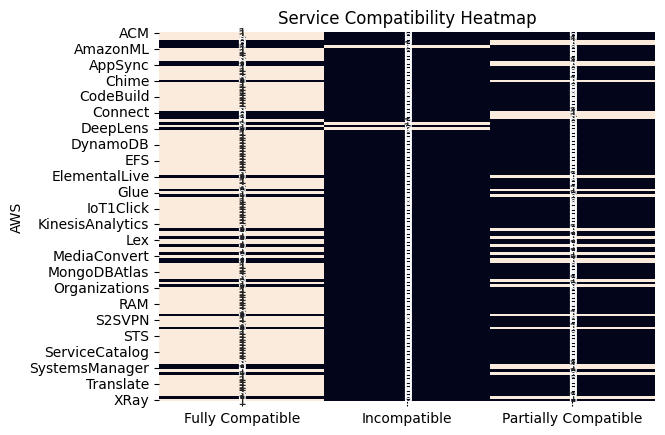

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Lock-In Index Distribution
plt.hist(architecture_df['lock_in_index'], bins=10, edgecolor='black')
plt.title('Lock-In Index Distribution')
plt.xlabel('Lock-In Index')
plt.ylabel('Number of Architectures')
plt.savefig('output/lock_in_index_distribution.png')

# Service Compatibility Heatmap
compatibility_matrix = mapping_df.pivot_table(index='AWS', values='Compatibility', aggfunc='first')
sns.heatmap(pd.get_dummies(compatibility_matrix, prefix='', prefix_sep=''), annot=True, cbar=False)
plt.title('Service Compatibility Heatmap')
plt.savefig('output/compatibility_heatmap.png')
